In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Read in titanic training data
titanic_df = pd.read_csv("../_Data/train_with_ages.csv")
titanic_testing_df = pd.read_csv("../_Data/test_with_ages.csv")
titanic_solutions_df = pd.read_csv("../_Data/solution_set.csv")
titanic_submission_df = titanic_testing_df

In [3]:
# Prepare solutions
titanic_submission_df = titanic_submission_df.replace('"', '', regex=True)
titanic_solutions_df = titanic_solutions_df.replace('"', '', regex=True)
titanic_solutions_df = titanic_submission_df.merge(titanic_solutions_df, how='left', left_on=["Name", "Ticket"], right_on=["name","ticket"])
titanic_solutions_df = titanic_solutions_df[['PassengerId', 'survived']]
#titanic_solutions_df.to_csv('../_Submission/010_temp_Submission_Solutions.csv', index=False)

In [4]:
# Set the fare to '0' for titanic_testing_df index '152'
def add_fare_values(fare):
    if fare >= 0:
        return fare
    else:
        return 0

titanic_testing_df['Fare'] = titanic_testing_df.apply(lambda row: add_fare_values(row['Fare']), axis=1)

In [5]:
# Calculate the number of relatives for each row
def add_relatives(sibsp, parch):
    return sibsp + parch

titanic_df['Relatives'] = titanic_df.apply(lambda row: add_relatives(row['SibSp'], row['Parch']), axis=1)
titanic_testing_df['Relatives'] = titanic_testing_df.apply(lambda row: add_relatives(row['SibSp'], row['Parch']), axis=1)

In [6]:
# Determine the per ticket price for each passenger.
titanic_combined_df = titanic_df.append(titanic_testing_df)
tickets = titanic_combined_df.groupby(['Ticket'])['PassengerId'].count().reset_index()

def fare_per_person(row):
    fare_per_person = row['Fare']/tickets[tickets.Ticket==row['Ticket']]['PassengerId']
    return fare_per_person.values[0]

titanic_df['FarePerPerson'] = titanic_df.apply(fare_per_person, axis=1)
titanic_testing_df['FarePerPerson'] = titanic_testing_df.apply(fare_per_person, axis=1)

In [7]:
# # Bin the fares
# def bin_fares(fare):
#     binned_fare = 0

#     if fare > 0.0 and fare <= 7.0:
#         binned_fare = 0
#     elif fare > 7.0 and fare <= 10.0:
#         binned_fare = 1
#     elif fare > 10.0 and fare <= 16.0:
#         binned_fare = 2
#     elif fare > 16.0 and fare <= 30.0:
#         binned_fare = 3
#     elif fare > 30.0 and fare <= 50.0:
#         binned_fare = 4
#     elif fare > 50.0:
#         binned_fare = 5

#     return binned_fare

# titanic_df['FarePPBinned'] = titanic_df.apply(lambda row: bin_fares(row['FarePerPerson']), axis=1)
# titanic_testing_df['FarePPBinned'] = titanic_testing_df.apply(lambda row: bin_fares(row['FarePerPerson']), axis=1)

In [8]:
# Bin the ages
def bin_age(age):
    binned_age = 0

    if age > 0 and age <= 15:
        binned_age = 0
    elif age > 15 and age <= 25:
        binned_age = 1
    elif age > 25 and age <= 35:
        binned_age = 2
    elif age > 35 and age <= 45:
        binned_age = 3
    elif age > 45 and age <= 55:
        binned_age = 4
    elif age > 55:
        binned_age = 5

    return binned_age

titanic_df['AgeBinned'] = titanic_df.apply(lambda row: bin_age(row['Age']), axis=1)
titanic_testing_df['AgeBinned'] = titanic_testing_df.apply(lambda row: bin_age(row['Age']), axis=1)

In [9]:
# Convert Female to 0 and Male to 1
titanic_df = titanic_df.replace('female', 0)
titanic_df = titanic_df.replace('male', 1)

titanic_testing_df = titanic_testing_df.replace('female', 0)
titanic_testing_df = titanic_testing_df.replace('male', 1)

In [10]:
# Impute 2 missing values of embarked with most common value of 'S'
titanic_df.Embarked.fillna(titanic_df.Embarked.describe().top, inplace=True)
titanic_testing_df.Embarked.fillna(titanic_testing_df.Embarked.describe().top, inplace=True)

In [11]:
# Drop columns that data that will not likely be helpful
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)
titanic_testing_df = titanic_testing_df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)

In [12]:
# Convert pandas dataframe into numpy array
titanic_np = titanic_df.to_numpy()
titanic_testing_np = titanic_testing_df.to_numpy()
print(f'Shape of titanic_np: {titanic_np.shape}')
print(f'Shape of titanic_testing_np: {titanic_testing_np.shape}')

Shape of titanic_np: (891, 6)
Shape of titanic_testing_np: (418, 5)


In [13]:
# Create separate numpy arrays for features and labels
titanic_features = titanic_np[:, 1:]
titanic_labels = titanic_np[:, 0:1]
titanic_testing_features = titanic_testing_np

print(f'Shape of titanic_features: {titanic_features.shape}')
print(f'Shape of titanic_labels: {titanic_labels.shape}')
print(f'Shape of titanic_testing_features: {titanic_testing_features.shape}')

Shape of titanic_features: (891, 5)
Shape of titanic_labels: (891, 1)
Shape of titanic_testing_features: (418, 5)


In [14]:
# Split the data into 90% training and 10% testing
features_train, features_test, labels_train, labels_test = train_test_split(titanic_features, titanic_labels, test_size=0.10, random_state=10)

print(f'Shape of features_train: {features_train.shape}')
print(f'Shape of labels_train: {labels_train.shape}')
print(f'Shape of features_test: {features_test.shape}')
print(f'Shape of labels_test: {labels_test.shape}')

Shape of features_train: (801, 5)
Shape of labels_train: (801, 1)
Shape of features_test: (90, 5)
Shape of labels_test: (90, 1)


In [15]:
# Perform a grid search for the chosen classifier
def grid_search(classifier, param_grid):
    classifier = GridSearchCV(classifier, param_grid, verbose=0, n_jobs=-1)
    classifier.fit(features_train, labels_train)
    classifier.best_params_
    print(classifier.best_params_)
    print(f'Best score: {classifier.best_score_}')

# Train and validate the model for the chosen classifier
def train_validate_model(model, algorithm):
    model = model.fit(features_train, labels_train)
    labels_predict = model.predict(features_test)

    accuracy = accuracy_score(labels_predict, labels_test)
    print(f"Accuracy for {algorithm}: {accuracy:.3f}")

    return model

# Predict Survived labels for testing dataset
def predict_testing_labels(model):
    labels_testing_predict = model.predict(titanic_testing_features)
    return labels_testing_predict

In [16]:
# Grid Search for Decision Tree Classifier
algorithm = "ANN"

if algorithm == "DT":
    dtc_grid_search = tree.DecisionTreeClassifier()
    param_grid = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]}
    grid_search(dtc_grid_search, param_grid)
elif algorithm == "LogReg":
    log_reg_grid_search = LogisticRegression()
    param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0]}
    grid_search(log_reg_grid_search, param_grid)
elif algorithm == "KNN":
    KNN_grid_search = KNeighborsClassifier()
    param_grid = {'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 6, 10, 12, 14, 16, 18, 20, 30, 40], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    grid_search(KNN_grid_search, param_grid)
elif algorithm == "SVC":
    SVC_grid_search = SVC()
    param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.01, 0.2, 0.6, 1], 'gamma': ['scale', 'auto']}
    grid_search(SVC_grid_search, param_grid)

In [17]:
# Decision Tree Classifier training and validation
if algorithm == "DT":
    dtc = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=26)
    model = train_validate_model(dtc, algorithm)
    labels_testing_predict = predict_testing_labels(model)
elif algorithm == "LogReg":
    log_reg = LogisticRegression(penalty='l2', C=0.1)
    model = train_validate_model(log_reg, algorithm)
    labels_testing_predict = predict_testing_labels(model)
elif algorithm == "KNN":
    knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=16, weights='distance')
    model = train_validate_model(knn, algorithm)
    labels_testing_predict = predict_testing_labels(model)
elif algorithm == "SVC":
    svc = SVC(C=1, gamma='auto', kernel='rbf')
    model = train_validate_model(svc, algorithm)
    labels_testing_predict = predict_testing_labels(model)

/250
801/801 [==============================] - 1s 791us/step - loss: 0.5139 - accuracy: 0.7403 - val_loss: 0.4003 - val_accuracy: 0.8333
Epoch 117/250
801/801 [==============================] - 1s 656us/step - loss: 0.4873 - accuracy: 0.7591 - val_loss: 0.4026 - val_accuracy: 0.8556
Epoch 118/250
801/801 [==============================] - 1s 750us/step - loss: 0.4888 - accuracy: 0.7678 - val_loss: 0.4104 - val_accuracy: 0.8444
Epoch 119/250
801/801 [==============================] - 1s 715us/step - loss: 0.4796 - accuracy: 0.7715 - val_loss: 0.3830 - val_accuracy: 0.8333
Epoch 120/250
801/801 [==============================] - 1s 685us/step - loss: 0.4791 - accuracy: 0.7665 - val_loss: 0.3911 - val_accuracy: 0.8444
Epoch 121/250
801/801 [==============================] - 1s 707us/step - loss: 0.4838 - accuracy: 0.7591 - val_loss: 0.3829 - val_accuracy: 0.8111
Epoch 122/250
801/801 [==============================] - 1s 691us/step - loss: 0.4955 - accuracy: 0.7578 - val_loss: 0.3841 - v

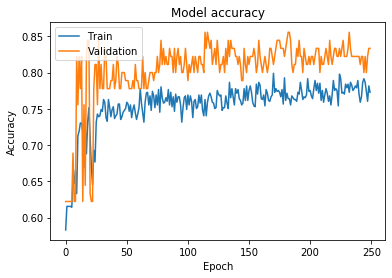

In [18]:
if algorithm == "ANN":
    # Convert the labels to one-hot encoding.
    n_classes = 2
    labels_train = np_utils.to_categorical(titanic_labels, n_classes)
    print(f'Shape of one hot encoded labels_train: {labels_train.shape}')

    # Add a 32 node hidden layer with sigmoid activation function.
    n_features = titanic_features.shape[1]

    model = Sequential()
    model.add(Dropout(0.15))
    model.add(Dense(1024, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1024, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1024, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(n_classes, input_dim=n_features, activation='sigmoid'))

    # Compile your model with accuracy as your metric.
    opt=Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model.
    model_history = model.fit(titanic_features, labels_train, epochs=250, batch_size=128, validation_split=0.10)

    # Predict the test set labels.
    labels_testing_predict = model.predict(titanic_testing_features)
    labels_testing_predict = np.argmax(labels_testing_predict, axis=-1)

    # Plot training & validation accuracy values
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [19]:
# Convert numpy labels array to dataframe
labels_testing_predict_df = pd.DataFrame(labels_testing_predict, index=None, columns=['Survived'])

In [20]:
# Copy the predicted survival labels to the submission dataframe and change column to int64
titanic_submission_df['Survived'] = labels_testing_predict_df['Survived']
titanic_submission_df['Survived'] = titanic_submission_df['Survived'].astype('int64')

In [21]:
# Drop all columns not needed for submission.
titanic_submission_df_final = titanic_submission_df.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)

In [22]:
# Write to CSV results file
#titanic_submission_df_final.to_csv('../_Submission/009_Ryan_Submission_ANN.csv', index=False)

In [23]:
# Calculate the accuracy versus the Kaggle test solutions (doesn't affect previous csv export)
titanic_submission_df_final = titanic_submission_df_final.drop(['PassengerId'], axis=1)
titanic_solutions_df = titanic_solutions_df.drop(['PassengerId'], axis=1)
titanic_solutions_df.columns = ['Survived']

accuracy_test = accuracy_score(titanic_solutions_df, titanic_submission_df_final)
print(f"Accuracy for test dataset: {accuracy_test:.3f}")

Accuracy for test dataset: 0.789


## Model results versus the Kaggle test set:

Test set accuracy for Decision Tree: 0.749 => (Added Fare per Person) 0.756 => (Added Relatives) 0.766 => (Binned Ages) 0.756

Test set accuracy for Logistic Regression: 0.763 => (Added Fare per Person) 0.763 => (Added Relatives) 0.756 => (Binned Ages) 0.756

Test set accuracy for KNN: 0.639 => (Added Fare per Person) 0.656 => (Added Relatives) 0.641 => (Binned Ages) 0.713

Test set accuracy for SVC: 0.766 => (Added Fare per Person) 0.766 => (Added Relatives) 0.766 => (Binned Ages) 0.722

Test set accuracy for ANN: 0.744 => (Added Fare per Person) 0.734 => (1024 Nodes & 300 epochs) 0.758 => (Added Relatives) 0.746 => (Binned Ages) 0.749 => (Sigmoid) 0.766 => (Dropouts 0.2) 0.775 => (Dropouts 0.3) 0.746 => (Dropouts 0.1) 0.789 => (Dropouts 0.15) 0.792 => (Dropouts 0.05) 0.778 => (Dropouts 0.15 and Binned Fare) 0.785 => (Dropouts 0.15) 0.792 => (Unbinned Age) 0.612 => (Dropouts 0.15 and Binned Age) 0.789